# Modelling

Feature engineering, model training, tuning, selection and explanability.

# 0. Load Packages and Define Helper Functions

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing import preprocess_df, clean_amenities
random_state = 42

import warnings
warnings.filterwarnings('ignore')

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from sklearn.preprocessing import LabelEncoder, power_transform

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder, RobustScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingRegressor

import miceforest as mf

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from sklearn.metrics import mean_squared_error
from keras import backend
import shap
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

In [35]:
def mice_impute(train_df):

    df = train_df.copy()
    
    numeric_col = []
    for col in df.columns:
        if df[col].dtype in ("int", "float"):
            numeric_col.append(col)
        
    #Scale values
    scaler = StandardScaler()

    scaled_features = scaler.fit_transform(df[numeric_col])
    scaled_features = pd.DataFrame(data=scaled_features, columns = numeric_col)


    for col in numeric_col:
        scaled_features[col] = scaled_features[col].astype(float)

    # MICE MI imputation
    # This is the first main step to create "kernel", which include the settings for this MI implementation. 
    kernel = mf.MultipleImputedKernel(
    scaled_features, # your dataset
    datasets=1, # number of dataset imputed
    random_state=1 # random seed
    ) 

    # Run the MICE algorithm for 3 iterations on each of the datasets. 3 to reduce computation time
    kernel.mice(3)
    scaled_features = kernel.complete_data(dataset=0) #Save imputed dataset


    #Scale back
    scaled_features = scaler.inverse_transform(scaled_features)
    scaled_features = pd.DataFrame(data=scaled_features, columns = numeric_col)

    df = pd.concat([df[list(set(train_df.columns)-set(numeric_col))], scaled_features], axis=1)

    return df


def fit_and_score(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    
    # Train metrics
    pred_train= model.predict(X_train)
    train_MSE = mean_squared_error(y_train, pred_train)
    
    # Cross validate
    cv_score = cross_validate(model, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'],n_jobs=2, verbose=1, cv = 5) 
    
    # Test metrics
    pred_test= model.predict(X_test)
    test_MSE = mean_squared_error(y_test, pred_test)
    
    print('Train R-sq', round(model.score(X_train, y_train),4))
    print('Train MSE:', round(train_MSE,4))
    print('')
    print('CV R-sq', round(np.mean(cv_score['test_r2']),4))
    print('CV MSE:', round(-np.mean(cv_score['test_neg_mean_squared_error']),4))
    print('')
    print('Test R-sq', round(model.score(X_test, y_test),4))
    print('Test MSE:', round(test_MSE,4))
    
    return model

def grid_search_pipe(model, grid, X_train, y_train):
    
    search = GridSearchCV(model, grid, cv=5,n_jobs=2, scoring='r2', verbose=1)
    search.fit(X_train, y_train)
    
    print("Best params:\n{}".format(search.best_params_))
    print("Best score:\n{}".format(search.best_score_)) #Mean cross-validated score of the best_estimator
    
    return search

# 1. Load and Preprocess

In [36]:
data = pd.read_csv('data/listings.csv.gz')
data.shape

(66641, 74)

In [37]:
data[['reviews_per_month']].describe()

reviews_per_month
count       48082.000000
mean            0.635780
std             1.037195
min             0.010000
25%             0.090000
50%             0.290000
75%             0.790000
max            57.660000

In [38]:
df = preprocess_df(data = data)
df.shape

(36705, 42)

In [39]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'bathroom_num', 'bathroom_sharing', 'price_log'],
      dtype='object')

In [40]:
df = clean_amenities(data = df, num_amenities =80)

In [41]:
df.head()

id  host_id host_since  host_is_superhost  host_total_listings_count  \
1   15400    60302 2020-03-16                  0                        1.0   
4   25123   103583 2020-03-15                  0                        3.0   
9   38610   165579 2020-08-12                  1                        2.0   
11  38995   167281 2020-02-21                  0                        1.0   
12  39387   168920 2019-11-03                  0                        1.0   

    host_has_profile_pic  host_identity_verified  \
1                      1                       1   
4                      1                       1   
9                      1                       1   
11                     1                       1   
12                     1                       0   

    neighbourhood_group_cleansed  latitude  longitude  ...  \
1                            0.0  51.48780   -0.16813  ...   
4                            0.0  51.57438   -0.21081  ...   
9                            0.0  51.50701   -0.23362  ...   
11                           0.0  51.47860   -0.06114  ...   
12                           0.0  51.52605   -0.19942  ...   

   amenities_central heating amenities_outdoor dining area  \
1                          0                             0   
4                          0                             0   
9                          0                             0   
11                         0                             0   
12                         0                             0   

    amenities_cleaning before checkout  amenities_clothing storage  \
1                                    0                           0   
4                                    0                           0   
9                                    1                           0   
11                                   0                           0   
12                                   0                           1   

    amenities_clothing storage: closet  amenities_mini fridge  \
1                                    0                      0   
4                                    0                      0   
9                                    0                      0   
11                                   0                      0   
12                                   0                      0   

    amenities_building staff  amenities_private fenced garden or backyard  \
1                          0                                            0   
4                          0                                            0   
9                          0                                            1   
11                         0                                            0   
12                         0                                            0   

    amenities_gym  amenities_children’s dinnerware  
1               0                                0  
4               0                                0  
9               0                                0  
11              0                                0  
12              0                                0  

[5 rows x 121 columns]

In [42]:
df['room_type'].value_counts()

Entire home/apt    22273
Private room       14119
Shared room          163
Hotel room           150
Name: room_type, dtype: int64

# 1. Feature Engineering

## Host Duration

In [43]:
# Last scraped date = 2021-12-07 (7th Dec)
df['host_duration'] = (pd.to_datetime('2021-12-10') - df['host_since']).dt.days

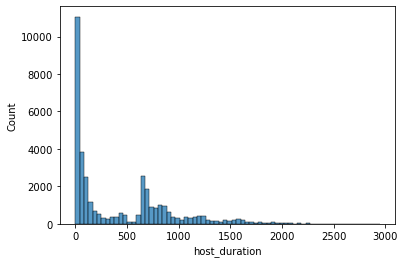

In [44]:
sns.histplot(df['host_duration'])
plt.show()

## Managed_property

In [45]:
# Understand how many properties are potentially property managed

percentiles=[0.80,0.85,0.90,0.95]
percentile_rooms=[]
room_above=[]

for p in percentiles:
   percentile_rooms.append(df.host_id.value_counts().quantile(p))

print('Understand managed property percentiles beyond P75\n')
print(pd.DataFrame({'percentile':percentiles,'rooms_threshold':percentile_rooms}))

property_count=pd.DataFrame(df.groupby(['host_id'])['host_id'].count())
property_count.columns=['properties']
property_count

Understand managed property percentiles beyond P75

   percentile  rooms_threshold
0        0.80              1.0
1        0.85              2.0
2        0.90              2.0
3        0.95              3.0


properties
host_id              
4775                7
5653                1
6774                3
9323                1
10657               2
...               ...
433334823           1
433435234           2
433572694           1
433837373           1
434015315           2

[24651 rows x 1 columns]

In [46]:
property_count['prop_managed']=property_count['properties'].map(lambda x: 1 if x>=percentile_rooms[3] else 0)
df=pd.merge(df,property_count,on='host_id',how='inner')
df.prop_managed.value_counts()

0    25508
1    11197
Name: prop_managed, dtype: int64

## Occupancy Rate

In [47]:
cols=['availability_30','availability_60', 'availability_90','availability_365']
df[cols].describe()

availability_30  availability_60  availability_90  availability_365
count     36705.000000     36705.000000     36705.000000      36705.000000
mean          6.451819        17.362730        29.587985        113.895273
std           9.166336        20.781427        33.256069        133.304336
min           0.000000         0.000000         0.000000          0.000000
25%           0.000000         0.000000         0.000000          0.000000
50%           0.000000         5.000000         9.000000         52.000000
75%          11.000000        36.000000        64.000000        231.000000
max          30.000000        60.000000        90.000000        365.000000

In [48]:
df['occ_30D']=1-round(df.availability_30/30,2)
df['occ_6090D']=((1-round(df.availability_60/60,2))+(1-round(df.availability_90/90,2)))/2
df['occ_365']=1-round(df.availability_365/365,2)

df=df.drop(cols,axis=1) # do not drop

In [49]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude',
       ...
       'amenities_building staff',
       'amenities_private fenced garden or backyard', 'amenities_gym',
       'amenities_children’s dinnerware', 'host_duration', 'properties',
       'prop_managed', 'occ_30D', 'occ_6090D', 'occ_365'],
      dtype='object', length=123)

## Location Variables

In [50]:
# Load computed location features
location_features = ['station', 'station_dist','walking_distance']
df = df.merge(pd.read_csv('computed_features/london_nearest_tube.csv')[['id']+location_features],left_on='id', right_on='id',how='left')
df.head()

id  host_id host_since  host_is_superhost  host_total_listings_count  \
0     15400    60302 2020-03-16                  0                        1.0   
1     25123   103583 2020-03-15                  0                        3.0   
2     41311   103583 2020-01-18                  0                        3.0   
3  19516454   103583 2020-03-20                  0                        3.0   
4     38610   165579 2020-08-12                  1                        2.0   

   host_has_profile_pic  host_identity_verified  neighbourhood_group_cleansed  \
0                     1                       1                           0.0   
1                     1                       1                           0.0   
2                     1                       1                           0.0   
3                     1                       1                           0.0   
4                     1                       1                           0.0   

   latitude  longitude  ... amenities_children’s dinnerware host_duration  \
0  51.48780   -0.16813  ...                               0           634   
1  51.57438   -0.21081  ...                               0           635   
2  51.57400   -0.21058  ...                               0           692   
3  51.57466   -0.20916  ...                               0           630   
4  51.50701   -0.23362  ...                               0           485   

   properties  prop_managed  occ_30D  occ_6090D  occ_365  \
0           1             0      1.0      1.000     0.99   
1           3             1      1.0      1.000     1.00   
2           3             1      0.9      0.960     0.99   
3           3             1      1.0      1.000     1.00   
4           1             0      0.8      0.335     0.07   

                 station  station_dist  walking_distance  
0       South Kensington    805.406363               0.0  
1            Brent Cross    302.665825               1.0  
2            Brent Cross    346.564965               1.0  
3            Brent Cross    361.025714               1.0  
4  Shepherds Bush Market    449.743591               3.0  

[5 rows x 126 columns]

## Sentiment

In [51]:
import pandas as pd
df_sentiment = pd.read_csv('computed_features/nc_eng_with_sent.csv')

df=pd.merge(df,df_sentiment,left_on='id', right_on='listing_id',how='left')
df = df.drop(['listing_id'], axis = 1)
df = df.fillna(df.mean())
df.head()

id_x  host_id host_since  host_is_superhost  host_total_listings_count  \
0     15400    60302 2020-03-16                  0                        1.0   
1     25123   103583 2020-03-15                  0                        3.0   
2     41311   103583 2020-01-18                  0                        3.0   
3  19516454   103583 2020-03-20                  0                        3.0   
4     38610   165579 2020-08-12                  1                        2.0   

   host_has_profile_pic  host_identity_verified  neighbourhood_group_cleansed  \
0                     1                       1                           0.0   
1                     1                       1                           0.0   
2                     1                       1                           0.0   
3                     1                       1                           0.0   
4                     1                       1                           0.0   

   latitude  longitude  ... walking_distance Unnamed: 0          id_y  \
0  51.48780   -0.16813  ...              0.0        1.0  8.029375e+07   
1  51.57438   -0.21081  ...              1.0        3.0  8.898858e+07   
2  51.57400   -0.21058  ...              1.0       10.0  1.066726e+08   
3  51.57466   -0.20916  ...              1.0    16621.0  4.596262e+08   
4  51.50701   -0.23362  ...              3.0        7.0  3.235218e+08   

    reviewer_id  comments_len  key_reviewer  negative   neutral  positive  \
0  2.695406e+07     78.062500      0.075000  0.016000  0.682400  0.301550   
1  3.434179e+07     61.970588      0.127451  0.011020  0.607324  0.381667   
2  3.536433e+07     71.552239      0.074627  0.007433  0.627463  0.365134   
3  1.034197e+08     44.500000      0.136364  0.003682  0.558909  0.437409   
4  8.901368e+07     86.068966      0.000000  0.007931  0.707483  0.284621   

   compound  
0  0.900261  
1  0.941062  
2  0.961803  
3  0.953786  
4  0.927310  

[5 rows x 135 columns]

In [52]:
df['x'] = np.cos(df['latitude']) * np.cos(df['longitude'])
df['y'] = np.cos(df['latitude']) * np.sin(df['longitude'])
df['z'] = np.sin(df['latitude'])

df.drop(['latitude', 'longitude'], axis = 1, inplace = True)
df

id_x    host_id host_since  host_is_superhost  \
0         15400      60302 2020-03-16                  0   
1         25123     103583 2020-03-15                  0   
2         41311     103583 2020-01-18                  0   
3      19516454     103583 2020-03-20                  0   
4         38610     165579 2020-08-12                  1   
...         ...        ...        ...                ...   
36700  53606541   52745934 2021-12-03                  0   
36701  53618701  433572694 2021-12-06                  0   
36702  53629457  314377938 2021-12-04                  0   
36703  53656459   50739127 2021-12-06                  0   
36704  53673183   23747528 2021-12-06                  0   

       host_total_listings_count  host_has_profile_pic  \
0                            1.0                     1   
1                            3.0                     1   
2                            3.0                     1   
3                            3.0                     1   
4                            2.0                     1   
...                          ...                   ...   
36700                        2.0                     1   
36701                        1.0                     0   
36702                        0.0                     1   
36703                        0.0                     1   
36704                        0.0                     1   

       host_identity_verified  neighbourhood_group_cleansed  \
0                           1                           0.0   
1                           1                           0.0   
2                           1                           0.0   
3                           1                           0.0   
4                           1                           0.0   
...                       ...                           ...   
36700                       1                           0.0   
36701                       1                           0.0   
36702                       0                           0.0   
36703                       0                           0.0   
36704                       1                           0.0   

                          property_type        room_type  ...   reviewer_id  \
0                    Entire rental unit  Entire home/apt  ...  2.695406e+07   
1      Private room in residential home     Private room  ...  3.434179e+07   
2      Private room in residential home     Private room  ...  3.536433e+07   
3      Private room in residential home     Private room  ...  1.034197e+08   
4                      Entire townhouse  Entire home/apt  ...  8.901368e+07   
...                                 ...              ...  ...           ...   
36700        Entire condominium (condo)  Entire home/apt  ...  2.304489e+06   
36701        Entire condominium (condo)  Entire home/apt  ...  1.201104e+08   
36702       Private room in rental unit     Private room  ...  3.227269e+08   
36703  Private room in residential home     Private room  ...  3.765545e+06   
36704           Private room in cottage     Private room  ...  6.900929e+07   

       comments_len  key_reviewer  negative   neutral  positive  compound  \
0         78.062500      0.075000  0.016000  0.682400  0.301550  0.900261   
1         61.970588      0.127451  0.011020  0.607324  0.381667  0.941062   
2         71.552239      0.074627  0.007433  0.627463  0.365134  0.961803   
3         44.500000      0.136364  0.003682  0.558909  0.437409  0.953786   
4         86.068966      0.000000  0.007931  0.707483  0.284621  0.927310   
...             ...           ...       ...       ...       ...       ...   
36700     42.000000      0.000000  0.000000  0.666000  0.334000  0.955800   
36701     46.173024      0.110482  0.014050  0.641245  0.344704  0.811415   
36702     74.000000      1.000000  0.027000  0.819000  0.154000  0.894600   
36703     41.000000      0.000000  0.265000  0.735000  0.000000 -0.904800   
36704     66.000000      0.000000  0.064

# 2. Feature selection

In [53]:
# Format columns
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [54]:
df.columns.tolist()

['id_x',
 'host_id',
 'host_since',
 'host_is_superhost',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'accommodates',
 'bedrooms',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'has_availability',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'reviews_per_month',
 'bathroom_num',
 'bathroom_sharing',
 'price_log',
 'amenities_wifi',
 'amenities_essentials',
 'amenities_smokealarm',
 'amenities_heating',
 'amenities_kitchen',
 'amenities_hangers',
 'amenities_longtermstaysallowed',
 'amenities_iron',
 'amenities_washer',
 'amenities_hairdryer',
 'amenities_ho

In [55]:
sentiment_features = [   'comments_len',
                         'neutral',
                         'negative',
                         'positive']

features_selected = ['host_total_listings_count',
                         'neighbourhood_group_cleansed',
                         'room_type',
                         'accommodates',
                         'bedrooms',
                         'minimum_nights',
                         'maximum_nights',
                         'minimum_nights_avg_ntm',
                         'maximum_nights_avg_ntm',
                         'number_of_reviews',
                         'number_of_reviews_ltm',
                         'number_of_reviews_l30d',
                         'review_scores_rating',
                         'review_scores_accuracy',
                         'review_scores_cleanliness',
                         'review_scores_checkin',
                         'review_scores_communication',
                         'review_scores_location',
                         'review_scores_value',
                         'reviews_per_month',
                         'bathroom_num',
                         'bathroom_sharing',
                        'amenities_wifi',
                        'amenities_essentials',
                        'amenities_smokealarm',
                        'amenities_heating',
                        'amenities_kitchen',
                        'amenities_hangers',
                        'amenities_longtermstaysallowed',
                        'amenities_iron',
                        'amenities_washer',
                        'amenities_hairdryer',
                        'amenities_hotwater',
                        'amenities_shampoo',
                        'amenities_carbonmonoxidealarm',
                        'amenities_dedicatedworkspace',
                        'amenities_dishesandsilverware',
                        'amenities_cookingbasics',
                        'amenities_refrigerator',
                        'amenities_bedlinens',
                        'amenities_tv',
                        'amenities_microwave',
                        'amenities_oven',
                        'amenities_stove',
                        'amenities_dryer',
                        'amenities_firstaidkit',
                        'amenities_fireextinguisher',
                        'amenities_coffeemaker',
                        'amenities_dishwasher',
                        'amenities_privateentrance',
                        'amenities_extrapillowsandblankets',
                        'amenities_luggagedropoffallowed',
                        'amenities_hostgreetsyou',
                        'amenities_lockbox',
                        'amenities_bathtub',
                        'amenities_elevator',
                        'amenities_freeparkingonpremises',
                        'amenities_showergel',
                        'amenities_paidparkingoffpremises',
                        'amenities_hotwaterkettle',
                        'amenities_backyard',
                        'amenities_freestreetparking',
                        'amenities_lockonbedroomdoor',
                        'amenities_cabletv',
                        'amenities_patioorbalcony',
                        'amenities_freezer',
                        'amenities_tvwithstandardcable',
                        'amenities_cleaningproducts',
                        'amenities_toaster',
                        'amenities_diningtable',
                        'amenities_wineglasses',
                        'amenities_roomdarkeningshades',
                        'amenities_bodysoap',
                        'amenities_breakfast',
                        'amenities_dryingrackforclothing',
                        'amenities_singlelevelhome',
                        'amenities_securitycamerasonproperty',
                        'amenities_conditioner',
                        'amenities_indoorfireplace',
                        'amenities_portablefans',
                        'amenities_ethernetconnection',
                        'amenities_outdoorfurniture',
                        'amenities_laundromatnearby',
                        'amenities_packnplaytravelcrib',
                        'amenities_crib',
                        'amenities_airconditioning',
                        'amenities_highchair',
                        'amenities_bakingsheet',
                        'amenities_bbqgrill',
                        'amenities_paidparkingonpremises',
                        'amenities_privatepatioorbalcony',
                        'amenities_centralheating',
                        'amenities_outdoordiningarea',
                        'amenities_childrensbooksandtoys',
                        'amenities_cleaningbeforecheckout',
                        'amenities_clothingstorage',
                        'amenities_clothingstoragecloset',
                        'amenities_minifridge',
                        'amenities_privatefencedgardenorbackyard',
                        'amenities_buildingstaff',
                         'host_duration',
                         'properties',
                         'x',
                         'y',
                         'z',
                         'occ_30D',
                         'occ_6090D',
                         'occ_365'] + location_features + sentiment_features

skewed_features = ['reviews_per_month','review_scores_rating','minimum_nights','maximum_nights','minimum_nights_avg_ntm', 'station_dist','walking_distance']

In [56]:
def run_SFM_rfr(X,y,n=65):
    # Categorical features encoding    
    X = pd.get_dummies(X, columns=cat_cols)

    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    feature_selector = SelectFromModel(estimator=LGBMRegressor(random_state = random_state),
                                       threshold='0.1*mean',
                                       max_features=n)

    X_train_sfm = feature_selector.fit_transform(X_train, y_train)
    X_test_sfm = feature_selector.transform(X_test)
    
    print('New shape: ',X_train_sfm.shape)
    print('Dropped ', X_train.shape[1]-X_train_sfm.shape[1], ' features')
    
    include=feature_selector.get_support()
    headers=X_train.columns

    fs=pd.DataFrame({'cols':headers,'include':include})
    filters=(fs.include==True)
    ncols=fs[filters].cols.to_list()

    X_train_sfm = pd.DataFrame(X_train_sfm, columns=ncols)
    X_test_sfm =pd.DataFrame(X_test_sfm, columns=ncols)
    
    cols = X_train_sfm.columns
    
    stdscaler = StandardScaler()
    X_train_trfm = stdscaler.fit_transform(X_train_sfm)
    X_test_trfm = stdscaler.transform(X_test_sfm)
    
    X_train_trfm = pd.DataFrame(X_train_trfm)
    X_train_trfm = X_train_trfm.set_axis(cols, axis=1, inplace=False)
    X_test_trfm = pd.DataFrame(X_test_trfm)
    X_test_trfm = X_test_trfm.set_axis(cols, axis=1, inplace=False)
    
    return X_train_trfm, X_test_trfm, y_train, y_test

In [57]:
y_variable = ['price_log']

# Set X and y features
X = df[features_selected]
X = X.drop(['station'],axis=1)
y = df[y_variable[0]].ravel()

In [58]:
# Numercial and categorical columns to process
num_cols = list(X.select_dtypes(include=np.number).columns)
cat_cols = list(set(X.columns)-set(X[num_cols].columns))

print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))
print(cat_cols)

X shape: (36705, 114)
y shape: (36705,)
['room_type', 'bathroom_sharing']


In [59]:
X_train, X_test, y_train, y_test = run_SFM_rfr(X,y)

New shape:  (29364, 65)
Dropped  54  features


In [60]:
# Numercial and categorical columns to process
num_cols = list(X_train.select_dtypes(include=np.number).columns)
cat_cols = list(set(X_train.columns)-set(X_train[num_cols].columns))

print('X shape: {}'.format(np.shape(X_train)))
print('y shape: {}'.format(np.shape(y_train)))
print(cat_cols)

X shape: (29364, 65)
y shape: (29364,)
[]


# 3. Models

## Additional EDA

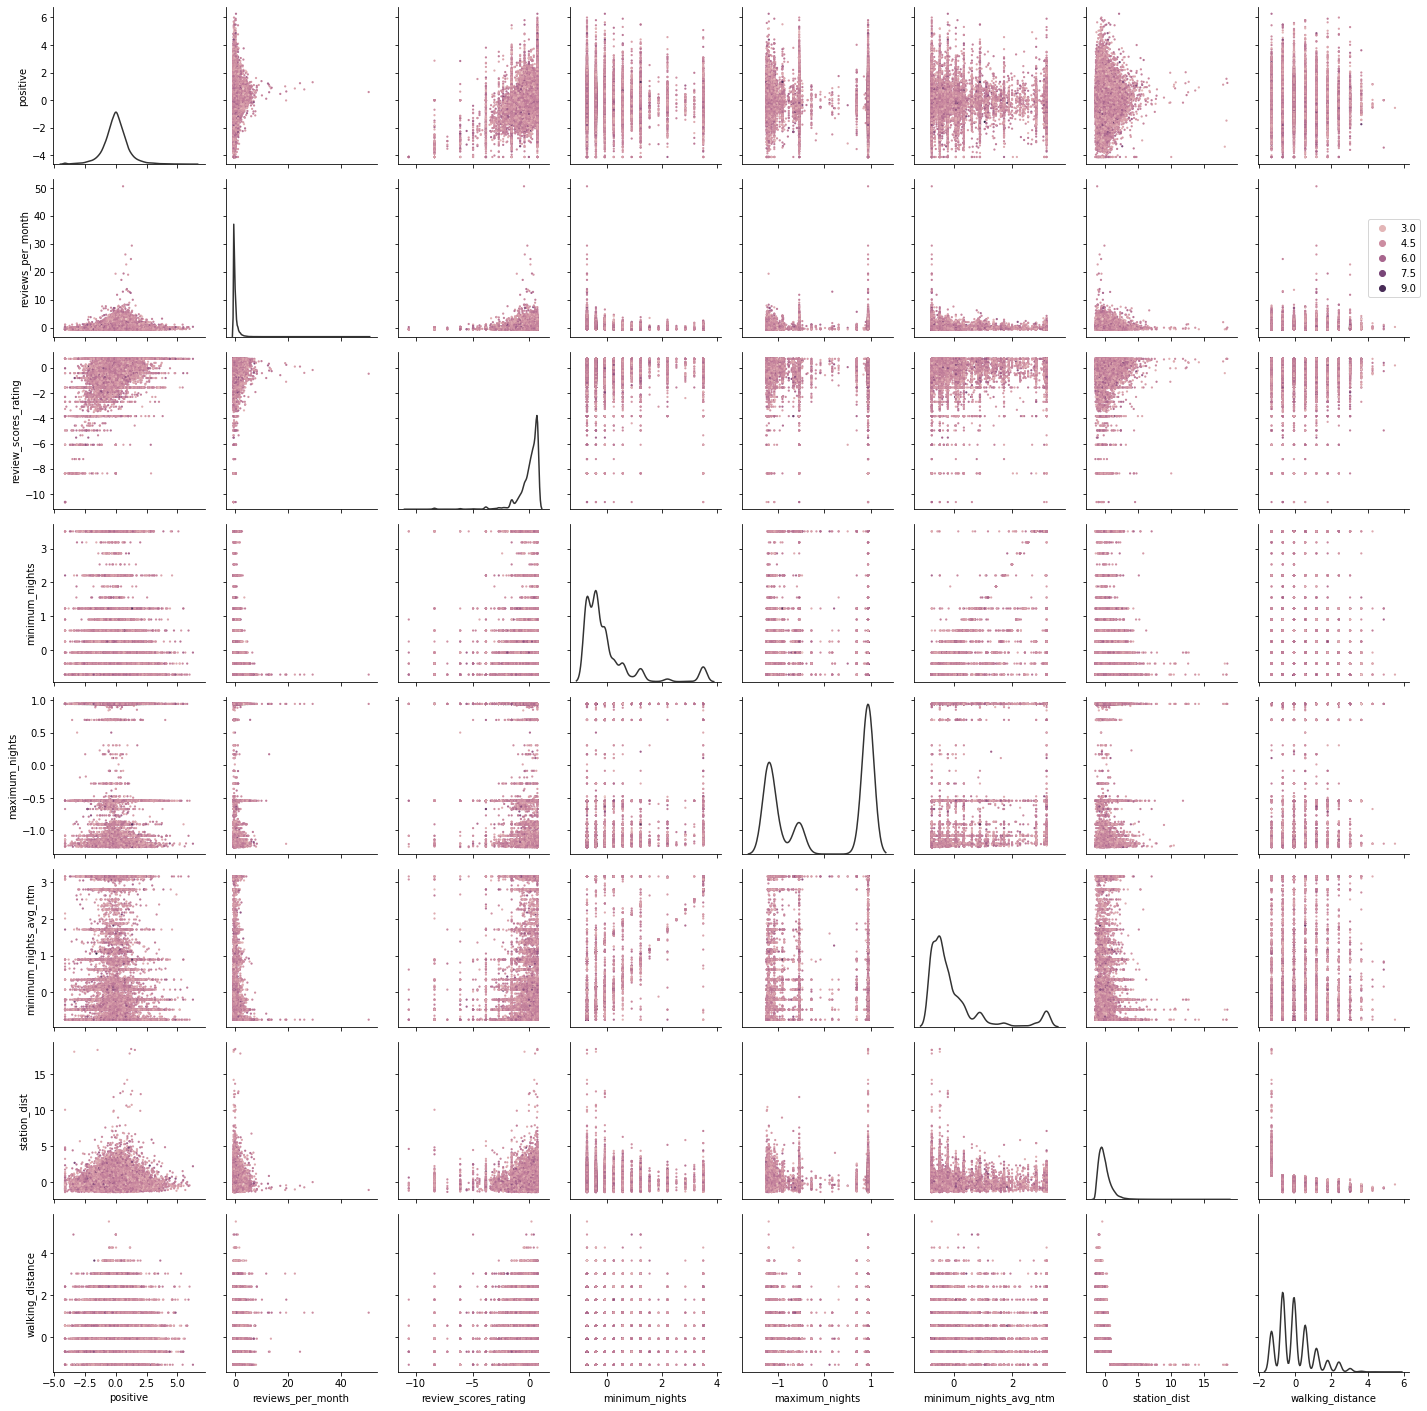

In [262]:
g = sns.PairGrid(X_train, vars=['positive']+skewed_features)
g.map_diag(sns.kdeplot, color=".2")
g.map_offdiag(sns.scatterplot, hue=df["price_log"], s=5, linewidth=0)
g.axes[1, -1].legend(loc="center left", bbox_to_anchor=(.7, .5))

In [263]:
# Transform skewed features
X_train[skewed_features] = power_transform(X_train[skewed_features], method='yeo-johnson')
X_test[skewed_features] = power_transform(X_test[skewed_features], method='yeo-johnson')


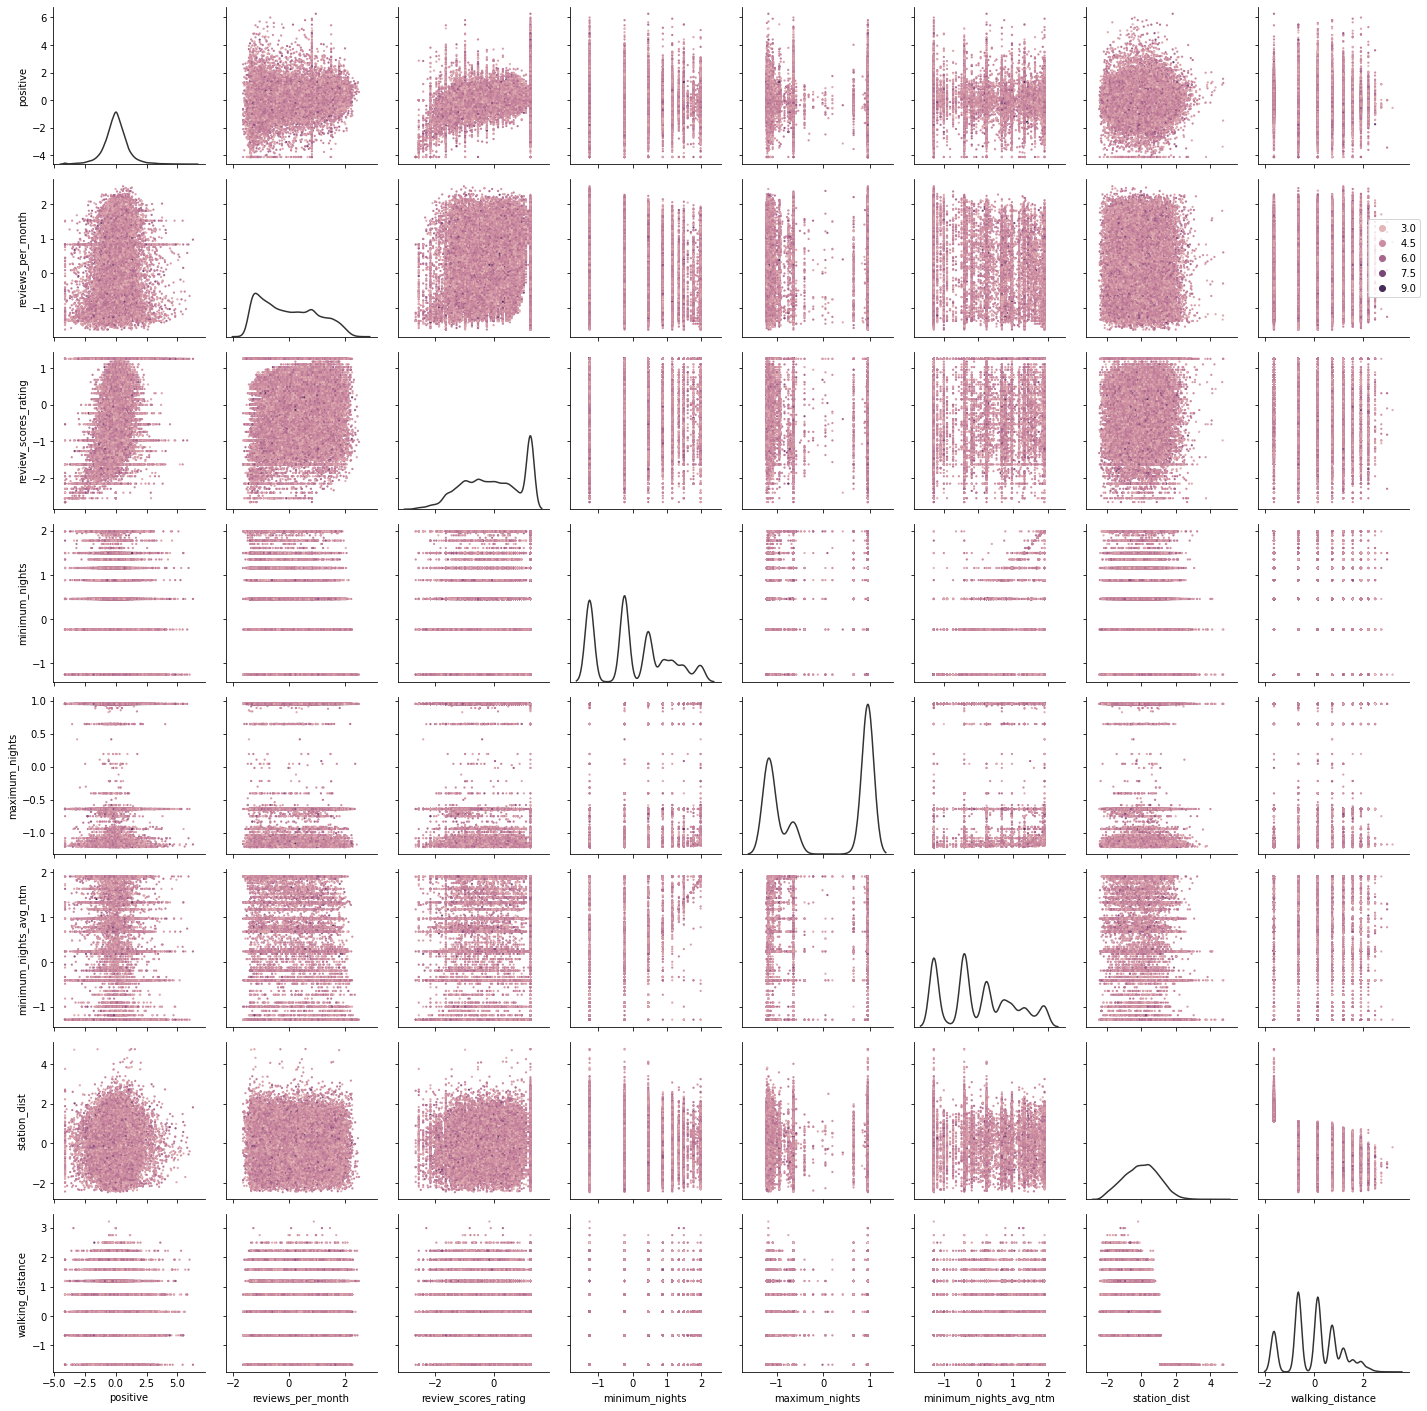

In [264]:
g = sns.PairGrid(X_train, vars=['positive']+skewed_features)
g.map_diag(sns.kdeplot, color=".2")
g.map_offdiag(sns.scatterplot, hue=df["price_log"], s=5, linewidth=0)
g.axes[1, -1].legend(loc="center left", bbox_to_anchor=(.7, .5))

## Linear Regression (Baseline)

In [61]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
lr = sm.OLS(y_train,sm.add_constant(X_train))
results = lr.fit()
#print('RMSE', results.mse_model)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     964.2
Date:                Sat, 23 Apr 2022   Prob (F-statistic):               0.00
Time:                        23:43:42   Log-Likelihood:                -17909.
No. Observations:               29364   AIC:                         3.595e+04
Df Residuals:                   29298   BIC:                         3.650e+04
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             4.4674      0.003   1717.237      0.000       4.462       4.472
host_total_listings_count         0.1261      0.003     40.001      0.000       0.120       0.132
accommodates                      0.1386      0.005     29.538      0.000       0.129       0.148
bedrooms                          0.1192      0.004     27.047      0.000       0.111       0.128
minimum_nights                   -0.0326      0.005     -6.152      0.000      -0.043      -0.022
maximum_nights                   -0.0030      0.003     -1.143      0.253      -0.008       0.002
minimum_nights_avg_ntm            0.0079      0.005      1.455      0.146      -0.003       0.018
maximum_nights_avg_ntm            0.0086      0.003      3.253      0.001       0.003       0.014
number_of_reviews                -0.0209      0.003     -6.293      0.000      -0.027      -0.014
number_of_reviews_ltm             0.0074      0.004      1.907      0.056      -0.000       0.015
number_of_reviews_l30d           -0.0255      0.004     -6.649      0.000      -0.033      -0.018
review_scores_rating              0.0565      0.007      8.618      0.000       0.044       0.069
review_scores_accuracy           -0.0156      0.006     -2.824      0.005      -0.026      -0.005
review_scores_cleanliness         0.0520      0.004     11.590      0.000       0.043       0.061
review_scores_checkin            -0.0304      0.005     -6.610      0.000      -0.039      -0.021
review_scores_communication      -0.0511      0.005    -10.155      0.000      -0.061      -0.041
review_scores_location            0.0826      0.004     22.233      0.000       0.075       0.090
review_scores_value              -0.0708      0.005    -12.926      0.000      -0.082      -0.060
reviews_per_month                -0.0045      0.004     -0.999      0.318      -0.013       0.004
bathroom_num                      0.0444      0.003     13.684      0.000       0.038       0.051
amenities_smokealarm             -0.0100      0.003     -3.519      0.000      -0.016      -0.004
amenities_kitchen                -0.0120      0.003     -4.105      0.000      -0.018      -0.006
amenities_iron                   -0.0135      0.003     -4.510      0.000      -0.019      -0.008
amenities_hairdryer               0.0110      0.004      2.492      0.013       0.002       0.020
amenities_hotwater               -0.0075      0.003     -2.231      0.026      -0.014      -0.001
amenities_shampoo                 0.0341      0.003     12.151      0.000       0.029       0.040
amenities_carbonmonoxidealarm     0.0169      0.003      5.865      0.000       0.011       0.023
amenities_refrigerator           -0.0166      0.004     -3.824      0.000      -0.025      -0.008
amenities_bedlinens              -0.0013     

In [62]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [63]:
cv_score = cross_validate(SMWrapper(sm.OLS), X_train, y_train, scoring=['r2','neg_mean_squared_error'],n_jobs=2, verbose=1, cv = 5) 
print('CV R-sq', round(np.mean(cv_score['test_r2']),4))
print('CV MSE:', round(-np.mean(cv_score['test_neg_mean_squared_error']),4))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CV R-sq 0.6783
CV MSE: 0.2001


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    3.0s finished


## XGB Regressor

### Tuning XGB

RandomizedSearch then GridSearch

In [269]:
xgb = XGBRegressor(random_state = random_state, use_label_encoder=False)

random_grid = {
    "n_estimators": range(50, 500, 50),
    "max_depth": range(2,20,2),
    'subsample': np.linspace(0.3, 1, 10),
    'colsample_bytree': np.linspace(0.2, 1, 5),
    'reg_lambda': np.linspace(0, 5, 11),
    'reg_alpha': np.linspace(0, 5, 11),
    'gamma': np.linspace(0, 5, 5)
}

search_xgb = RandomizedSearchCV(xgb, random_grid, cv=5,n_jobs=2, scoring='r2', n_iter = 100, verbose=1)
search_xgb.fit(X_train, y_train)

print("Best params:\n{}".format(search_xgb.best_params_))
print("Best score:\n{}".format(search_xgb.best_score_)) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   54.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.8min finished


[17:56:09] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "xgbregressor__colsample_bytree", "xgbregressor__gamma", "xgbregressor__max_depth", "xgbregressor__n_estimators", "xgbregressor__reg_alpha", "xgbregressor__reg_lambda", "xgbregressor__subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best params:
{'xgbregressor__subsample': 0.37777777777777777, 'xgbregressor__reg_lambda': 5.0, 'xgbregressor__reg_alpha': 2.0, 'xgbregressor__n_estimators': 50, 'xgbregressor__max_depth': 6, 'xgbregressor__gamma': 3.75, 'xgbregressor__colsample_bytree': 0.2}
Best score:
0.7687670285525356


In [ ]:
grid = {
    "n_estimators": [500,600,700],
    "max_depth": [5,6,8],
    'subsample': [0.9],
    'colsample_bytree': [0.4],
    'reg_lambda': [1,2,3],
    'reg_alpha': [2,3.5,4.5],
    'gamma': [2,3.75]
}

grid_xgb = GridSearchCV(xgb, grid, cv=5,n_jobs=3, scoring='r2', verbose=1)
grid_xgb.fit(X_train, y_train)

print("Best params:\n{}".format(grid_xgb.best_params_))
print("Best score:\n{}".format(grid_xgb.best_score_)) 

### XGB Best

In [104]:
xgb_best = XGBRegressor(random_state = random_state,
                        use_label_encoder=False,
                        subsample = 0.88,
                        reg_alpha = 2,
                        n_estimators = 700, 
                        max_depth = 5, 
                        max_bin = 10,
                        gamma = 2,
                        colsample_bytree = 0.4
                        )

xgb_model = fit_and_score(model = xgb_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   22.1s finished


Train R-sq 0.8276
Train MSE: 0.1073

CV R-sq 0.7693
CV MSE: 0.1435

Test R-sq 0.7871
Test MSE: 0.1284


## LGBM Regressor

### Tuning LGBM

In [270]:
lgb = LGBMRegressor(random_state = random_state)
                    
random_grid = { 'boosting_type': ['gbdt','dart','goss'],
                'n_estimators': range(50, 500, 50),
                'max_bin':range(2, 20, 2),
                'num_leaves':range(10, 200, 10),
                'max_depth': np.arange(2,20,2).tolist(),
                'colsample_bytree' : np.linspace(0.2, 1, 5),
                'subsample' : np.linspace(0.3, 1, 10)}


search_lgb = RandomizedSearchCV(lgb, random_grid, cv=5,n_jobs=3, scoring='r2', n_iter = 20, verbose=1)
search_lgb.fit(X_train, y_train)

print("Best params:\n{}".format(search_lgb.best_params_))
print("Best score:\n{}".format(search_lgb.best_score_)) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   10.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   18.4s finished


Best params:
{'lgbmregressor__subsample': 0.45555555555555555, 'lgbmregressor__num_leaves': 140, 'lgbmregressor__n_estimators': 350, 'lgbmregressor__max_depth': 12, 'lgbmregressor__max_bin': 8, 'lgbmregressor__colsample_bytree': 0.6000000000000001, 'lgbmregressor__boosting_type': 'dart'}
Best score:
0.7733313407464099


In [83]:
grid= {  'boosting_type': ['gbdt'],
         'n_estimators': [550,500,450],
         'max_bin':[10],
         'num_leaves': [35,40,45],
         'max_depth': [6,7,8],
         'colsample_bytree' : [0.4,0.5,0.6],
         'subsample' : [0.50,0.55,0.60]}

grid_lgb = GridSearchCV(lgb, grid, cv=5,n_jobs=4, scoring='r2', verbose=1)
grid_lgb.fit(X_train, y_train)

print("Best params:\n{}".format(grid_lgb.best_params_))
print("Best score:\n{}".format(grid_lgb.best_score_)) 

Fitting 2 folds for each of 243 candidates, totalling 486 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 486 out of 486 | elapsed:  2.7min finished


Best params:
{'boosting_type': 'gbdt', 'colsample_bytree': 0.6, 'max_bin': 10, 'max_depth': 6, 'n_estimators': 450, 'num_leaves': 45, 'subsample': 0.5}
Best score:
0.7684122497005698


### Best LGBM

In [88]:
lgbm_best = LGBMRegressor(random_state = random_state,
                        boosting_type = 'gbdt',
                        colsample_bytree = 0.4,
                        max_bin = 10,
                        max_depth = 6,
                        n_estimators = 450,
                        num_leaves = 40,
                        subsample = 0.50)
        
lgb_t = fit_and_score(model = lgbm_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    5.3s finished


Train R-sq 0.8828
Train MSE: 0.0729

CV R-sq 0.7785
CV MSE: 0.1378

Test R-sq 0.7906
Test MSE: 0.1262


## Random Forest Regressor

### Tuning RFR

In [ ]:
rf = RandomForestRegressor(random_state = random_state)

random_grid = {'randomforestregressor__max_features':['auto','sqrt','log2'],
                'randomforestregressor__n_estimators': range(100,500,50),
                'randomforestregressor__bootstrap': [True,False],
                'randomforestregressor__oob_score':[True,False],
                'randomforestregressor__max_depth': range(2, 20, 2),
                'randomforestregressor__ccp_alpha' : np.arange(0.01, 0.30,0.02).tolist(),
              'randomforestregressor__min_samples_split' : range(1,5,1)}


rsearch_rf = RandomizedSearchCV(rf, random_grid, cv=5,n_jobs=2, scoring='r2', n_iter = 100, verbose=1)
rsearch_rf.fit(X_train, y_train)

print("Best params:\n{}".format(rsearch_rf.best_params_))
print("Best score:\n{}".format(rsearch_rf.best_score_))

In [ ]:
grid = {'randomforestregressor__max_features':['log2'],
        'randomforestregressor__n_estimators': [200, 250, 300, 350],
        'randomforestregressor__bootstrap': [True],
        'randomforestregressor__oob_score':[False],
        'randomforestregressor__max_depth': [14, 18, 22],
        'randomforestregressor__ccp_alpha' : [0.0, 0.01, 0.05],
        'randomforestregressor__min_samples_split' : [2, 3, 4]}

gsearch_rf = GridSearchCV(rf, grid, cv=5,n_jobs=3, scoring='r2', verbose=1)
gsearch_rf.fit(X_train, y_train)

print("Best params:\n{}".format(gsearch_rf.best_params_))
print("Best score:\n{}".format(gsearch_rf.best_score_)) 

### Best RFR

In [110]:
rf_best = RandomForestRegressor(random_state = random_state,
                                max_features = 'log2',
                                n_estimators = 400,
                                bootstrap = True,
                                oob_score = False,
                                max_depth = 20,
                                ccp_alpha = 0.0,
                                min_samples_split = 2
                                )

rf_model_tuned = fit_and_score(model = rf_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.1min finished


Train R-sq 0.9502
Train MSE: 0.031

CV R-sq 0.748
CV MSE: 0.1568

Test R-sq 0.7633
Test MSE: 0.1427


## Stacking Regressor

In [37]:
estimators = [
    ("XGBoost Classifier", xgb_best),
    ("LGBM Classifier", lgbm_best),
    ("Random Forest Classifier", rf_best)
]

stacking_regressor = StackingRegressor(estimators=estimators, 
                                         final_estimator=LGBMRegressor(random_state=random_state))
stacking_regressor

StackingRegressor(estimators=[('XGBoost Classifier',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.6,
                                            enable_categorical=False, gamma=2,
                                            gpu_id=-1, importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=8,
                                            min_child_weight=1, missing=nan,
                                            monotone_constrai...
                                            use_label_encoder=False,
                                            validate_parameters=1,
                                            verbosity=None)),
                              ('LGBM Classifier',
                               LGBMRegressor(colsample_bytree=0.4, max_bin=10,
                                             max_depth=12, n_estimators=350,
                                             num_leaves=35, random_state=42,
                                             subsample=0.5)),
                              ('Random Forest Classifier',
                               RandomForestRegressor(max_depth=22,
                                                     max_features='log2',
                                                     n_estimators=250,
                                                     random_state=42))],
                  final_estimator=LGBMRegressor(random_state=42))

### Stacking L1 Tuning

GridSearch only

In [ ]:
# Tune LightGBM at Level 1
grid = {'final_estimator__n_estimators': [50, 100, 150, 200, 250],
               'final_estimator__max_depth': [2, 4, 6, 8, 10]}

search = grid_search_pipe(model = stacking_regressor, 
                            grid = grid, 
                            X_train = X_train, 
                            y_train = y_train) 

### Best Stacker

In [111]:
estimators = [
    ("LGBM Classifier", lgbm_best),
    ("XGBoost Classifier", xgb_best),
    ("Random Forest Classifier", rf_best)
]

stacking_regressor_best = StackingRegressor(estimators=estimators, final_estimator=LGBMRegressor(random_state=random_state, max_depth = 4, n_estimators = 50))
stacking_regressor_best

StackingRegressor(estimators=[('LGBM Classifier',
                               LGBMRegressor(colsample_bytree=0.4, max_bin=10,
                                             max_depth=6, n_estimators=450,
                                             num_leaves=40, random_state=42,
                                             subsample=0.5)),
                              ('XGBoost Classifier',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.4, gamma=2,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_co...
                                            random_state=42, reg_alpha=2,
                                            reg_lambda=1, scale_pos_weight=1,
                                            subsample=0.88, tree_method='exact',
                                            use_label_encoder=False,
                                            validate_parameters=1,
                                            verbosity=None)),
                              ('Random Forest Classifier',
                               RandomForestRegressor(max_depth=20,
                                                     max_features='log2',
                                                     n_estimators=400,
                                                     random_state=42))],
                  final_estimator=LGBMRegressor(max_depth=4, n_estimators=50,
                                                random_state=42))

In [112]:
stacking_regressor_best = fit_and_score(model = stacking_regressor_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  7.6min finished


Train R-sq 0.897
Train MSE: 0.0641

CV R-sq 0.7845
CV MSE: 0.134

Test R-sq 0.7977
Test MSE: 0.122


## Neural Network

In [41]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def r2(y_true, y_pred):
    SS_res =  backend.sum(backend.square( y_true-y_pred )) 
    SS_tot = backend.sum(backend.square( y_true - backend.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + backend.epsilon()) )

### Baseline NN

In [42]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(65, input_dim=65, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,r2])
    return model
model_bl = baseline_model()
model_bl.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65)                4290      
                                                                 
 batch_normalization (BatchN  (None, 65)               260       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 65)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 66        
                                                                 
Total params: 4,616
Trainable params: 4,486
Non-trainable params

In [43]:
epoch=100
history_bl = model_bl.fit(X_train, y_train, epochs=epoch, validation_split=0.05, verbose=1)

Train on 27895 samples, validate on 1469 samples
Epoch 1/100
27895/27895 [==============================] - 1s 53us/sample - loss: 1.7206 - rmse: 0.8141 - r2: -2.0255 - val_loss: 0.2744 - val_rmse: 0.3791 - val_r2: 0.5389
Epoch 2/100
27895/27895 [==============================] - 1s 44us/sample - loss: 0.2640 - rmse: 0.3824 - r2: 0.5454 - val_loss: 0.2358 - val_rmse: 0.3466 - val_r2: 0.5903
Epoch 3/100
27895/27895 [==============================] - 1s 39us/sample - loss: 0.2377 - rmse: 0.3624 - r2: 0.5910 - val_loss: 0.2214 - val_rmse: 0.3329 - val_r2: 0.6206
Epoch 4/100
27895/27895 [==============================] - 1s 39us/sample - loss: 0.2235 - rmse: 0.3487 - r2: 0.6172 - val_loss: 0.2096 - val_rmse: 0.3235 - val_r2: 0.6426
Epoch 5/100
27895/27895 [==============================] - 1s 36us/sample - loss: 0.2112 - rmse: 0.3384 - r2: 0.6361 - val_loss: 0.2039 - val_rmse: 0.3258 - val_r2: 0.6494
Epoch 6/100
27895/27895 [==============================] - 1s 36us/sample - loss: 0.2054 -

27895/27895 [==============================] - 1s 29us/sample - loss: 0.1512 - rmse: 0.2811 - r2: 0.7449 - val_loss: 0.1855 - val_rmse: 0.3006 - val_r2: 0.6918
Epoch 96/100
27895/27895 [==============================] - 1s 29us/sample - loss: 0.1494 - rmse: 0.2794 - r2: 0.7470 - val_loss: 0.1881 - val_rmse: 0.2981 - val_r2: 0.6690
Epoch 97/100
27895/27895 [==============================] - 1s 32us/sample - loss: 0.1504 - rmse: 0.2811 - r2: 0.7454 - val_loss: 0.1888 - val_rmse: 0.2926 - val_r2: 0.6781
Epoch 98/100
27895/27895 [==============================] - 1s 32us/sample - loss: 0.1520 - rmse: 0.2823 - r2: 0.7411 - val_loss: 0.1787 - val_rmse: 0.2936 - val_r2: 0.6921
Epoch 99/100
27895/27895 [==============================] - 1s 29us/sample - loss: 0.1523 - rmse: 0.2831 - r2: 0.7421 - val_loss: 0.1748 - val_rmse: 0.2942 - val_r2: 0.7016
Epoch 100/100
27895/27895 [==============================] - 1s 29us/sample - loss: 0.1517 - rmse: 0.2818 - r2: 0.7451 - val_loss: 0.1822 - val_rmse

In [44]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history_bl.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history_bl.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='MSE')
fig.show()

### Best Baseline NN

In [45]:
best_model_bl = baseline_model()
best_model_bl.summary()
epoch=50
best_history_bl = best_model_bl.fit(X_train, y_train, epochs=epoch, validation_split=0.05, verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 65)                4290      
                                                                 
 batch_normalization_1 (Batc  (None, 65)               260       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 65)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 66        
                                                                 
Total params: 4,616
Trainable params: 4,486
Non-trainable params: 130
_________________________________________________________________


In [46]:
from sklearn.model_selection import KFold
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
mse_per_fold = []
r2_per_fold = []
# K-fold Cross Validation model evaluation
for train, test in kfold.split(X_train, y_train):
    X_val = X_train.iloc[test]
    y_val = y_train[test]
    # Define the model architecture
    model = baseline_model()

    # Fit data to model
    history = model.fit(X_train.iloc[train], y_train[train],
              epochs=epoch,
              verbose=0,
              validation_data=(X_val,y_val))

    # Generate generalization metrics
    mse_per_fold.append(history.history['val_loss'][epoch-1])
    r2_per_fold.append(history.history['val_r2'][epoch-1])

print('CV R-sq: ', round(np.mean(r2_per_fold),4))
print('CV MSE: ', round(np.mean(mse_per_fold),4))

CV R-sq:  0.691
CV MSE:  0.183


In [47]:
mse_nn, rmse_nn, r2_nn = best_model_bl.evaluate(X_test, y_test)
print('Train R-sq: ', round(best_history_bl.history['r2'][epoch-1],4))
print('Train MSE: ', round(best_history_bl.history['loss'][epoch-1],4))
print('Val R-sq: ', round(best_history_bl.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(best_history_bl.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

Train R-sq:  0.7227
Train MSE:  0.1638
Val R-sq:  0.6566
Val MSE:  0.2061
Test R-sq:  0.6587
Test MSE:  0.188


### Deep NN

In [48]:
def deep_model():
    # create model
    model = Sequential()
    model.add(Dense(65, input_dim=65, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(32, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(16, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,r2])
    return model
model_dp = deep_model()
model_dp.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 65)                4290      
                                                                 
 batch_normalization_7 (Batc  (None, 65)               260       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 65)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                2112      
                                                                 
 batch_normalization_8 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 32)               

In [49]:
epoch=100
history_dp = model_dp.fit(X_train, y_train, epochs=epoch, validation_split=0.05, verbose=0)

In [50]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history_dp.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history_dp.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='MSE')
fig.show()

### Best Deep NN

In [51]:
best_model_dp = deep_model()
best_model_dp.summary()
epoch=50
best_history_dp = best_model_dp.fit(X_train, y_train, epochs=epoch, validation_split=0.05, verbose=0)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 65)                4290      
                                                                 
 batch_normalization_10 (Bat  (None, 65)               260       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 65)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                2112      
                                                                 
 batch_normalization_11 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 32)               

In [52]:
from sklearn.model_selection import KFold
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
mse_per_fold = []
r2_per_fold = []
# K-fold Cross Validation model evaluation
for train, test in kfold.split(X_train, y_train):
    X_val = X_train.iloc[test]
    y_val = y_train[test]
    # Define the model architecture
    model = deep_model()

    # Fit data to model
    history = model.fit(X_train.iloc[train], y_train[train],
              epochs=epoch,
              verbose=0,
              validation_data=(X_val,y_val))

    # Generate generalization metrics
    mse_per_fold.append(history.history['val_loss'][epoch-1])
    r2_per_fold.append(history.history['val_r2'][epoch-1])

print('CV R-sq: ', round(np.mean(r2_per_fold),4))
print('CV MSE: ', round(np.mean(mse_per_fold),4))

CV R-sq:  0.7346
CV MSE:  0.1577


In [53]:
mse_nn, rmse_nn, r2_nn = best_model_dp.evaluate(X_test, y_test)
print('Train R-sq: ', round(best_history_dp.history['r2'][epoch-1],4))
print('Train MSE: ', round(best_history_dp.history['loss'][epoch-1],4))
print('Val R-sq: ', round(best_history_dp.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(best_history_dp.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

Train R-sq:  0.7726
Train MSE:  0.1318
Val R-sq:  0.7391
Val MSE:  0.1471
Test R-sq:  0.7478
Test MSE:  0.1441


### Wide NN

In [54]:
def wide_model():
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=65, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,r2])
    return model
model_wd = wide_model()
model_wd.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 128)               8448      
                                                                 
 batch_normalization_28 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9,089
Trainable params: 8,833
Non-trainable params: 256
_________________________________________________________________


In [55]:
epoch=100
history_wd = model_wd.fit(X_train, y_train, epochs=epoch, validation_split=0.05, verbose=0)

In [56]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history_wd.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history_wd.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='MSE')
fig.show()

### Best Wide NN

In [57]:
best_model_wd = wide_model()
best_model_wd.summary()
epoch=30
best_history_wd = best_model_wd.fit(X_train, y_train, epochs=epoch, validation_split=0.05, verbose=0)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 128)               8448      
                                                                 
 batch_normalization_29 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 activation_29 (Activation)  (None, 128)               0         
                                                                 
 dense_45 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9,089
Trainable params: 8,833
Non-trainable params: 256
_________________________________________________________________


In [58]:
from sklearn.model_selection import KFold
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
mse_per_fold = []
r2_per_fold = []
# K-fold Cross Validation model evaluation
for train, test in kfold.split(X_train, y_train):
    X_val = X_train.iloc[test]
    y_val = y_train[test]
    # Define the model architecture
    model = wide_model()

    # Fit data to model
    history = model.fit(X_train.iloc[train], y_train[train],
              epochs=epoch,
              verbose=0,
              validation_data=(X_val,y_val))

    # Generate generalization metrics
    mse_per_fold.append(history.history['val_loss'][epoch-1])
    r2_per_fold.append(history.history['val_r2'][epoch-1])

print('CV R-sq: ', round(np.mean(r2_per_fold),4))
print('CV MSE: ', round(np.mean(mse_per_fold),4))

CV R-sq:  0.6957
CV MSE:  0.1802


In [59]:
mse_nn, rmse_nn, r2_nn = best_model_wd.evaluate(X_test, y_test)
print('Train R-sq: ', round(best_history_wd.history['r2'][epoch-1],4))
print('Train MSE: ', round(best_history_wd.history['loss'][epoch-1],4))
print('Val R-sq: ', round(best_history_wd.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(best_history_wd.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

Train R-sq:  0.7446
Train MSE:  0.1487
Val R-sq:  0.7303
Val MSE:  0.1602
Test R-sq:  0.7282
Test MSE:  0.1551


# 4. Explainability and Feature Importance


### Permutation Feature Importance

In [113]:
# def plot_feature_importance(name, model_pipeline):
    
result = permutation_importance(stacking_regressor_best, X_test, y_test, n_repeats=5, random_state=42)

feature_names = [f"{i}" for i in X_train.columns]
importances = result.importances_mean
std = result.importances_std

my_dict = {'feature_names': feature_names, 'feature_impt': importances, 'std': std}

pi = pd.DataFrame.from_dict(my_dict)
pi.sort_values(by = 'feature_impt', ascending = False, inplace = True)


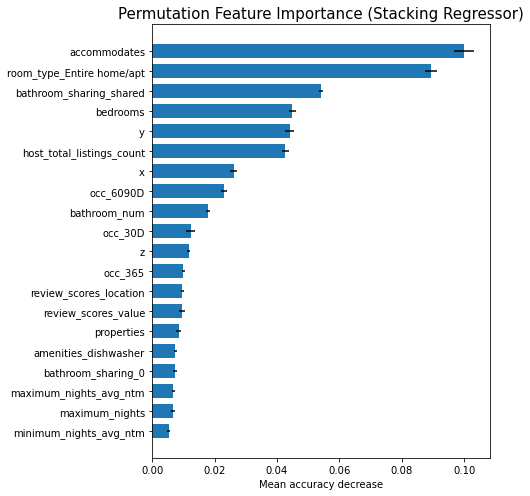

In [115]:
# Visualize feature importances
pi_top20 = pi[0:20]
name = 'Stacking Regressor'
fig, ax = plt.subplots(figsize=[7,7])
plt.barh(y = pi_top20['feature_names'], width = pi_top20['feature_impt'], xerr=pi_top20['std'], height = 0.7)
ax.set_title("Permutation Feature Importance ({})".format(name), fontsize = 15)
ax.set_xlabel("Mean accuracy decrease")
ax.invert_yaxis()  # labels read top-to-bottom
fig.tight_layout()
plt.show()

### SHAP Values

In [116]:
import shap

In [131]:
explainer = shap.TreeExplainer(lgbm_best)
shap_values = explainer.shap_values(X_train)
np.shape(shap_values)

(29364, 65)

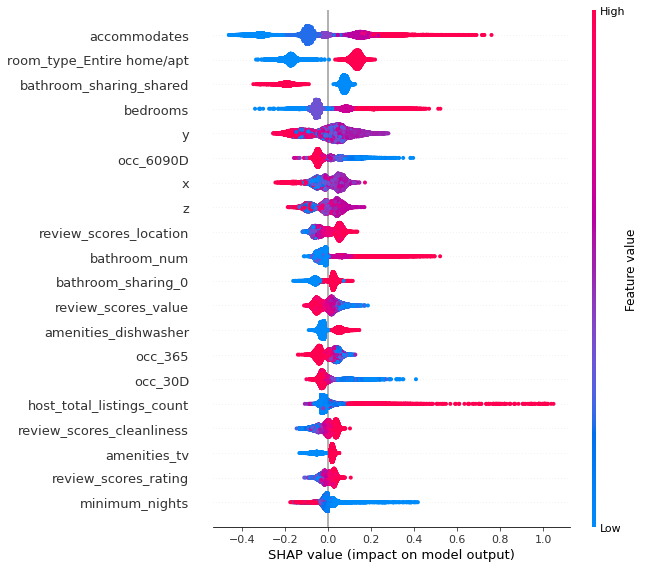

In [132]:
# Global summary plot
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train)
plt.show()

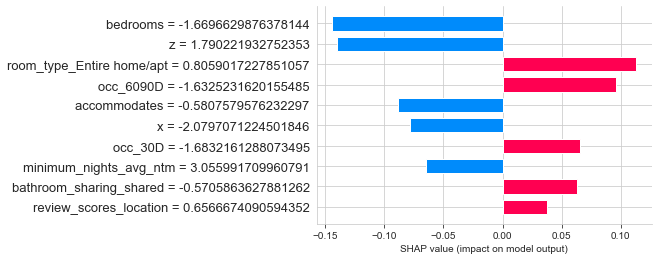

In [188]:
## Local sample explanation
shap.plots._bar.bar_legacy(shap_values[1], X_train.iloc[1],max_display = 10)

### Neural Network SHAP

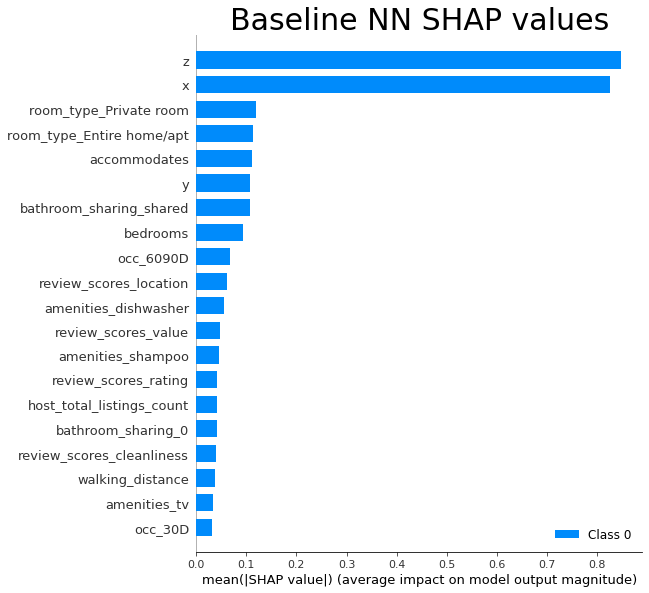

In [72]:
explainer = shap.DeepExplainer(best_model_bl,X_train[:100])
shap_values = explainer.shap_values(X_train.values)
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train, show=False)
plt.title("Baseline NN SHAP values",size=30)
plt.show()

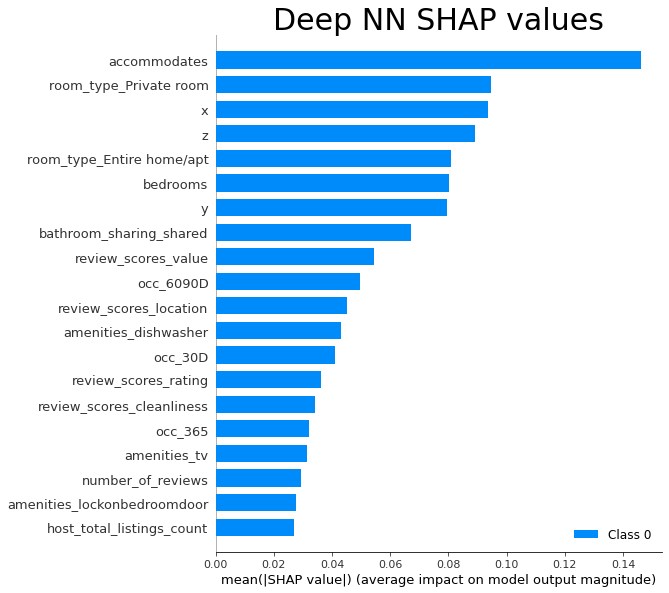

In [73]:
explainer = shap.DeepExplainer(best_model_dp,X_train[:100])
shap_values = explainer.shap_values(X_train.values)
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train, show=False)
plt.title("Deep NN SHAP values",size=30)
plt.show()

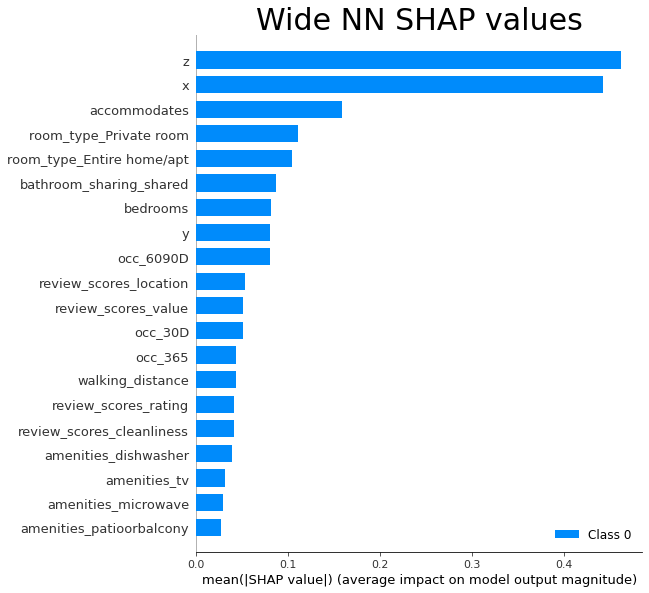

In [74]:
explainer = shap.DeepExplainer(best_model_wd,X_train[:100])
shap_values = explainer.shap_values(X_train.values)
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train, show=False)
plt.title("Wide NN SHAP values",size=30)
plt.show()

### Actual vs Predicted

In [159]:
import matplotlib.cm as cm
sns.set_style("whitegrid")
import matplotlib.colors as mcolors

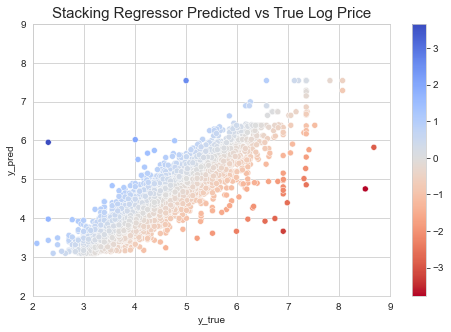

In [160]:
stacking_regressor_best.fit(X_train, y_train)
pred = stacking_regressor_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Stacking Regressor Predicted vs True Log Price', fontsize = 15)
plt.show()

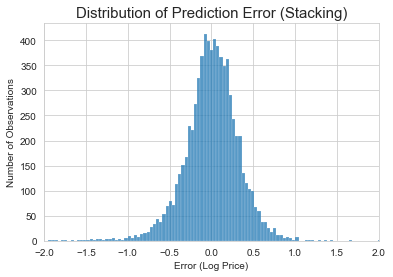

In [161]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Stacking)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()

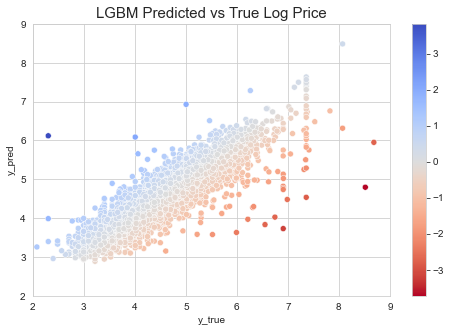

In [162]:

lgbm_best.fit(X_train, y_train)
pred = lgbm_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('LGBM Predicted vs True Log Price', fontsize = 15)
plt.show()

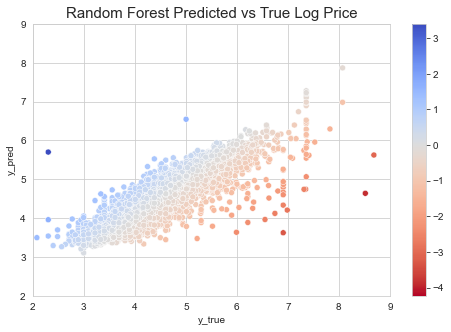

In [163]:
rf_best.fit(X_train, y_train)
pred = rf_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Random Forest Predicted vs True Log Price', fontsize = 15)
plt.show()

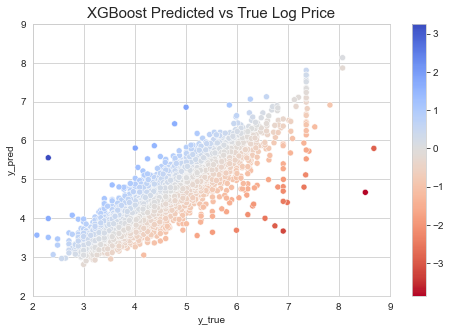

In [164]:
xgb_best.fit(X_train, y_train)
pred = xgb_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('XGBoost Predicted vs True Log Price', fontsize = 15)
plt.show()

### Neural Network Actual VS Predicted

In [83]:
import matplotlib.cm as cm
sns.set_style("whitegrid")
import matplotlib.colors as mcolors

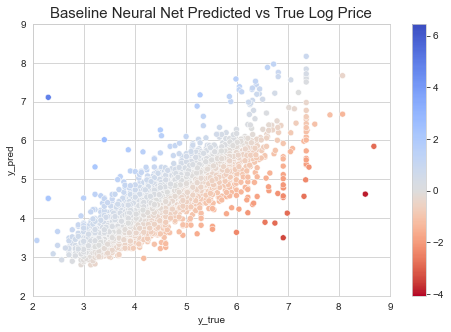

In [85]:
pred = best_model_bl.predict(X_test)[:,0]
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Baseline Neural Net Predicted vs True Log Price', fontsize = 15)
plt.show()

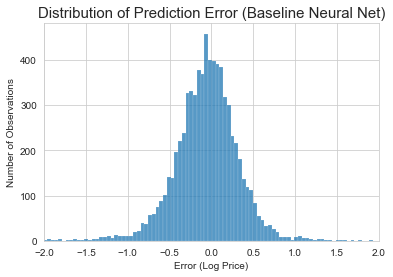

In [86]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Baseline Neural Net)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()

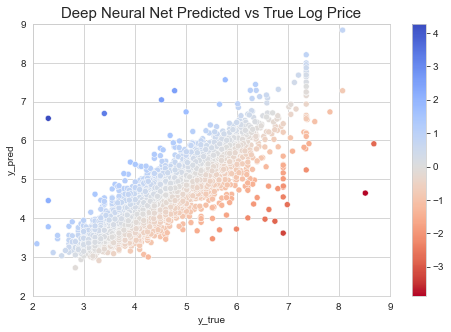

In [87]:
pred = best_model_dp.predict(X_test)[:,0]
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Deep Neural Net Predicted vs True Log Price', fontsize = 15)
plt.show()

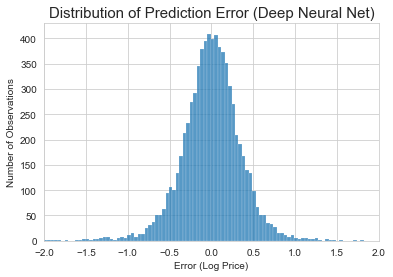

In [88]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Deep Neural Net)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()

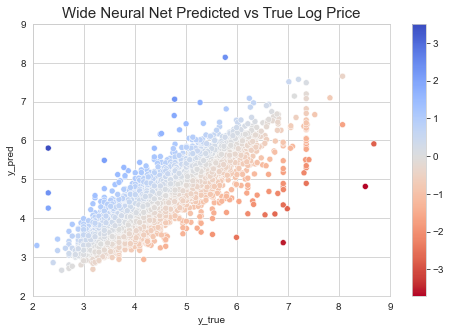

In [89]:
pred = best_model_wd.predict(X_test)[:,0]
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Wide Neural Net Predicted vs True Log Price', fontsize = 15)
plt.show()

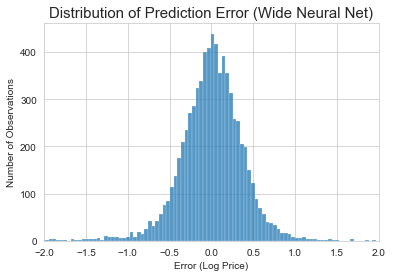

In [90]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Wide Neural Net)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()